In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from __future__ import annotations
import argparse, time, sys, os
from pathlib import Path
from typing import Tuple, List
import optuna

# Verify that we are learning correct option value

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ContinuationValueNet(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, t_norm, logS):
        x = torch.stack([t_norm, logS], dim=1)  # shape: (B, 2)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)


def simulate_paths(S0, r, sigma, T, num_steps, N):
    S = np.zeros((N, num_steps+1), dtype=np.float32)
    S[:, 0] = S0
    dt = T / num_steps
    for t in range(num_steps):
        z = np.random.randn(N).astype(np.float32)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
    return S


def evaluate_sharp_policy(net, num_eval_paths=20000):
    # Simulate new paths
    S_eval = simulate_paths(S0, r, sigma, T, num_steps, num_eval_paths)
    S_eval_torch = torch.from_numpy(S_eval).float().to(device)
    B = S_eval_torch.size(0)

    survival = torch.ones(B, device=device)
    total_payoffs = torch.zeros(B, device=device)

    normal_dist = Normal(0., 1.)

    for t in range(num_steps):
        t_norm = float(t) / num_steps
        discount = np.exp(-r * (t * dt))
        payoff_now = torch.clamp(K - S_eval_torch[:, t], min=0.0)
        payoff_disc = payoff_now * discount
        logS_t = torch.log(S_eval_torch[:, t] + 1e-12)
        cont_val = net(
            torch.full((B,), t_norm, dtype=torch.float32, device=device),
            logS_t
        )
        x = (payoff_disc - cont_val) / 1.0  # using soft_sigma=1 for example
        p_t = normal_dist.cdf(x)
        total_payoffs += survival * p_t * payoff_disc
        survival = survival * (1.0 - p_t)

    # forced exercise at final
    payoff_end = torch.clamp(K - S_eval_torch[:, num_steps], min=0.0)
    payoff_end_disc = payoff_end * np.exp(-r * T)
    total_payoffs += survival * payoff_end_disc

    return total_payoffs.mean().item()


def train_and_evaluate_for_sigma_fast(soft_sigma,
                                      num_epochs=30,
                                      num_train_paths=10000,
                                      num_eval_paths=20000,
                                      batch_size=200,
                                      seed=None):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    S_data = simulate_paths(S0, r, sigma, T, num_steps, num_train_paths)  # shape (N, num_steps+1)
    S_data_torch = torch.from_numpy(S_data).float().to(device)

    net = ContinuationValueNet(hidden_size=32).to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)

    steps_per_epoch = num_train_paths // batch_size
    epoch_rewards = []

    normal_dist = Normal(0., 1.)  # for CDF calls
    discount_factors = torch.exp(-r * dt * torch.arange(num_steps, device=device).float())

    for epoch in range(num_epochs):
        idx_perm = np.random.permutation(num_train_paths)
        batch_rewards = []

        for step_i in range(steps_per_epoch):
            idx_batch = idx_perm[step_i * batch_size : (step_i+1) * batch_size]
            S_batch = S_data_torch[idx_batch]  
            B = S_batch.shape[0]

            t_vals = torch.arange(num_steps, device=device, dtype=torch.float32) 
            t_norms = (t_vals / num_steps).repeat(B)  

            logS = torch.log(S_batch[:, :num_steps] + 1e-12) 
            logS_flat = logS.reshape(-1)                    

            cont_val_all = net(t_norms, logS_flat)
            cont_val_all = cont_val_all.view(B, num_steps)

            survival = torch.ones(B, device=device)
            total_payoffs = torch.zeros(B, device=device)

            payoff_now = torch.clamp(K - S_batch[:, :num_steps], min=0.0)  
            payoff_disc = payoff_now * discount_factors.unsqueeze(0)      

            for t in range(num_steps):
                x_t = (payoff_disc[:, t] - cont_val_all[:, t]) / soft_sigma
                p_t = normal_dist.cdf(x_t)

                instant_reward = survival * p_t * payoff_disc[:, t]
                total_payoffs += instant_reward

                survival = survival * (1.0 - p_t)

            payoff_end = torch.clamp(K - S_batch[:, num_steps], min=0.0)
            payoff_end_disc = payoff_end * np.exp(-r * T)
            total_payoffs += survival * payoff_end_disc

            optimizer.zero_grad()
            batch_mean = total_payoffs.mean()
            loss = -batch_mean
            loss.backward()
            optimizer.step()

            batch_rewards.append(batch_mean.item())

        epoch_rewards.append(np.mean(batch_rewards))

    # Evaluate final net
    final_price = evaluate_sharp_policy(net, num_eval_paths)
    return final_price, net, epoch_rewards


def run_multi_experiments_fast(sigma_values,
                               num_repeats=4,
                               num_epochs=200,
                               num_train_paths=10000,
                               num_eval_paths=20000,
                               batch_size=200):
    all_results = {}

    for sigma_soft in sigma_values:
        print(f"=== sigma_soft = {sigma_soft} ===")
        final_prices = []
        epoch_curves_list = []

        for repeat_idx in range(num_repeats):
            seed_val = 1234 + repeat_idx
            fp, net, epoch_rewards = train_and_evaluate_for_sigma_fast(
                soft_sigma=sigma_soft,
                num_epochs=num_epochs,
                num_train_paths=num_train_paths,
                num_eval_paths=num_eval_paths,
                batch_size=batch_size,
                seed=seed_val
            )
            final_prices.append(fp)
            epoch_curves_list.append(epoch_rewards)
            print(f"   Repeat {repeat_idx+1}/{num_repeats}, final price={fp:.4f}")

        all_results[sigma_soft] = {
            'final_prices': final_prices,
            'epoch_curves': epoch_curves_list
        }

    return all_results


def summarize_results(all_results):
    summary = {}
    print("\nSummary of final prices over multiple runs:\n")
    print("sigma_soft | avg_price  | std_dev    | max_price")
    print("-----------------------------------------------")
    for sigma_soft, data in all_results.items():
        prices = np.array(data['final_prices'])
        avg_p = prices.mean()
        std_p = prices.std()
        max_p = prices.max()
        summary[sigma_soft] = (avg_p, std_p, max_p)
        print(f"{sigma_soft:9.3f} | {avg_p:10.4f} | {std_p:10.4f} | {max_p:9.4f}")
    return summary


def plot_results(summary):
    sigma_list = sorted(summary.keys())
    avg_prices = [summary[s][0] for s in sigma_list]
    std_devs   = [summary[s][1] for s in sigma_list]
    max_prices = [summary[s][2] for s in sigma_list]

    plt.figure()
    plt.errorbar(sigma_list, avg_prices, yerr=std_devs, fmt='o')
    plt.xlabel("sigma_soft")
    plt.ylabel("Final Price (Average ± Std)")
    plt.title("Final Price vs. sigma_soft")

    plt.show()

# Option Constants

In [ ]:
S0 = 40.0
r = 0.06
sigma = 0.4
K = 40
T = 1.0
num_steps = 50
dt = T / num_steps

=== sigma_soft = 2 ===
   Repeat 1/5, final price=4.9150
   Repeat 2/5, final price=4.9535
   Repeat 3/5, final price=5.0195
   Repeat 4/5, final price=4.9149
   Repeat 5/5, final price=5.1190

Summary of final prices over multiple runs:

sigma_soft | avg_price  | std_dev    | max_price
-----------------------------------------------
    2.000 |     4.9844 |     0.0774 |    5.1190


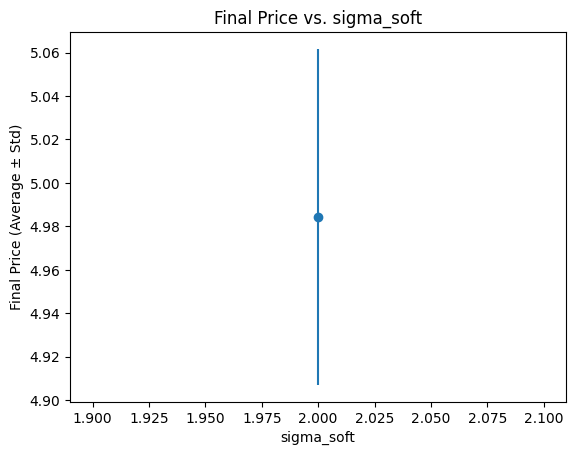

In [3]:
all_results = run_multi_experiments_fast(
    sigma_values=[2],
    num_repeats=5,
    num_epochs=10,       
    num_train_paths=20000, 
    num_eval_paths=30000,
    batch_size=1000     
)

summary_stats = summarize_results(all_results)
plot_results(summary_stats)


# Full Param Sweep

In [22]:
class ContinuationValueNet(nn.Module):
    def __init__(self, num_layers: int, hidden_size: int, activation: str):
        super().__init__()
        act_cls   = nn.ReLU if activation == "relu" else nn.LeakyReLU
        layers    = [nn.Linear(2, hidden_size), act_cls()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_size, hidden_size), act_cls()]
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, t_norm: torch.Tensor, logS: torch.Tensor):
        x = torch.stack([t_norm, logS], dim=1)
        return self.net(x).squeeze(-1)

def train_and_evaluate(
    *,
    num_layers: int,
    hidden_size: int,
    activation: str,
    optimiser_name: str,
    lr: float,
    soft_sigma: float,
    num_epochs: int,
    num_train_paths: int,
    num_eval_paths: int,
    batch_size: int,
    seed: int | None = None,
) -> Tuple[float, float, List[float]]:
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    S_train = simulate_paths(S0, r, sigma, T, num_steps, num_train_paths)
    S_train = torch.from_numpy(S_train).float().to(device)

    net       = ContinuationValueNet(num_layers, hidden_size, activation).to(device)
    optimiser = (optim.Adam if optimiser_name == "adam" else optim.SGD)(net.parameters(), lr=lr)

    normal_cdf       = Normal(0.0, 1.0).cdf
    discount_factors = torch.exp(-r * _dt * torch.arange(num_steps, device=device).float())

    steps_per_epoch  = num_train_paths // batch_size
    epoch_means      = []

    torch.autograd.set_detect_anomaly(True)

    for _ in range(num_epochs):
        perm   = np.random.permutation(num_train_paths)
        means_this_epoch = []
        for i in range(steps_per_epoch):
            idx    = perm[i * batch_size : (i+1) * batch_size]
            S_b    = S_train[idx]                      # (B, num_steps+1)
            B      = S_b.size(0)

            t_vals      = torch.arange(num_steps, device=device, dtype=torch.float32)
            t_norms     = (t_vals / num_steps).repeat(B)
            logS_flat   = torch.log(S_b[:, :num_steps] + 1e-12).reshape(-1)
            cont_vals   = net(t_norms, logS_flat).view(B, num_steps)

            survival    = torch.ones(B, device=device)
            total_p     = torch.zeros(B, device=device)
            payoff_now  = torch.clamp(K - S_b[:, :num_steps], min=0.0)
            payoff_disc = payoff_now * discount_factors.unsqueeze(0)

            for t in range(num_steps):
                x_t          = (payoff_disc[:, t] - cont_vals[:, t]) / soft_sigma
                p_t          = normal_cdf(x_t)
                instant      = survival * p_t * payoff_disc[:, t]
                total_p      = total_p + instant                  # out-of-place!
                survival     = survival * (1.0 - p_t)

            payoff_end      = torch.clamp(K - S_b[:, num_steps], min=0.0)
            payoff_end_disc = payoff_end * np.exp(-r * T)
            total_p         = total_p + survival * payoff_end_disc  # out-of-place!

            loss = -total_p.mean()
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            means_this_epoch.append((-loss).item())
        epoch_means.append(np.mean(means_this_epoch))

    mean_r, var_r = evaluate_policy(net, num_eval_paths)
    return mean_r, var_r, epoch_means


def evaluate_policy(net: nn.Module, num_paths: int = 20_000) -> Tuple[float, float]:
    S_eval  = simulate_paths(S0, r, sigma, T, num_steps, num_paths)
    S_eval  = torch.from_numpy(S_eval).float().to(device)
    B       = S_eval.size(0)
    normal_cdf = Normal(0.0, 1.0).cdf

    survival    = torch.ones(B, device=device)
    total_p     = torch.zeros(B, device=device)
    discount_factors = torch.exp(-r * _dt * torch.arange(num_steps, device=device).float())

    for t in range(num_steps):
        t_norm  = torch.full((B,), t / num_steps, dtype=torch.float32, device=device)
        logS_t  = torch.log(S_eval[:, t] + 1e-12)
        cont_t  = net(t_norm, logS_t)
        payoff  = torch.clamp(K - S_eval[:, t], min=0.0)
        disc    = payoff * discount_factors[t]
        x_t     = (disc - cont_t) / 1.0
        p_t     = normal_cdf(x_t)
        total_p = total_p + survival * p_t * disc
        survival= survival * (1.0 - p_t)

    payoff_end      = torch.clamp(K - S_eval[:, num_steps], min=0.0)
    payoff_end_disc = payoff_end * np.exp(-r * T)
    total_p         = total_p + survival * payoff_end_disc

    mean_ = total_p.mean().item()
    var_  = total_p.std(unbiased=True).item() / np.sqrt(num_paths)
    return mean_, var_

def objective(trial: optuna.Trial):
    hp_num_layers = trial.suggest_int("num_layers", 1, 3)
    hp_hidden     = trial.suggest_categorical("hidden_size", [32, 64])
    hp_lr         = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hp_activation = trial.suggest_categorical("activation", ["relu", "leaky_relu"])
    hp_optim      = trial.suggest_categorical("optimiser", ["adam", "sgd"])
    hp_sigma_soft = trial.suggest_float("sigma_soft", 0.01, 10.0, log=True)

    mean_r, var_r, epoch_curve = train_and_evaluate(
        num_layers      = hp_num_layers,
        hidden_size     = hp_hidden,
        activation      = hp_activation,
        optimiser_name  = hp_optim,
        lr              = hp_lr,
        soft_sigma      = hp_sigma_soft,
        num_epochs      = 25,
        num_train_paths = 8000,
        num_eval_paths  = 10000,
        batch_size      = 256,
        seed            = SEED,
    )

    trial.set_user_attr("curve", epoch_curve)
    trial.set_user_attr("mean_reward", mean_r)
    trial.set_user_attr("var_reward",  var_r)

    # multi-objective return
    return mean_r, var_r   # maximise first, minimise second


def run_study(*, n_trials: int = 40, timeout: int | None = None, storage: str | None = None):
    study = optuna.create_study(
        study_name = "architecture_optimisation",
        directions = ["maximize", "minimize"],
        storage    = storage,
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    return study

Running on: cpu


In [23]:
study_multi = run_study(
    n_trials = 150,
    storage  = "sqlite:///neural.db",  
)

[I 2025-07-19 19:13:26,526] A new study created in RDB with name: architecture_optimisation


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-07-19 19:14:22,324] Trial 0 finished with values: [4.271252155303955, 0.028298931121826174] and parameters: {'num_layers': 1, 'hidden_size': 32, 'lr': 0.0002496082109660876, 'activation': 'leaky_relu', 'optimiser': 'sgd', 'sigma_soft': 1.0922202356924369}. 
[I 2025-07-19 19:15:22,233] Trial 1 finished with values: [5.275866985321045, 0.05750143051147461] and parameters: {'num_layers': 2, 'hidden_size': 64, 'lr': 0.009479266273123586, 'activation': 'leaky_relu', 'optimiser': 'sgd', 'sigma_soft': 0.7648279649044859}. 
[I 2025-07-19 19:16:22,684] Trial 2 finished with values: [1.3504247665405273, 0.010537042617797851] and parameters: {'num_layers': 3, 'hidden_size': 32, 'lr': 0.0002276823111876614, 'activation': 'leaky_relu', 'optimiser': 'sgd', 'sigma_soft': 0.05431451451727968}. 
[I 2025-07-19 19:17:23,238] Trial 3 finished with values: [1.7175359725952148, 0.011364405155181884] and parameters: {'num_layers': 3, 'hidden_size': 32, 'lr': 3.244731094452203e-05, 'activation': 'relu

# Sigma_Soft Optimisation

In [6]:
def objective(trial: optuna.Trial):
    hp_num_layers = 2
    hp_hidden     = 32
    hp_lr         = 0.005
    hp_activation = "relu"
    hp_optim      = "sgd"
    hp_sigma_soft = trial.suggest_float("sigma_soft", 0.01, 10.0, log=True)

    mean_r, var_r, epoch_curve = train_and_evaluate(
        num_layers      = hp_num_layers,
        hidden_size     = hp_hidden,
        activation      = hp_activation,
        optimiser_name  = hp_optim,
        lr              = hp_lr,
        soft_sigma      = hp_sigma_soft,
        num_epochs      = 25,
        num_train_paths = 8000,
        num_eval_paths  = 10000,
        batch_size      = 256,
        seed            = SEED,
    )

    trial.set_user_attr("curve", epoch_curve)
    trial.set_user_attr("mean_reward", mean_r)
    trial.set_user_attr("var_reward",  var_r)

    return mean_r, var_r   # maximise first, minimise second


def run_study(*, n_trials: int = 40, timeout: int | None = None, storage: str | None = None):
    study = optuna.create_study(
        study_name = "sigma_choices_with_se",
        directions = ["maximize", "minimize"],
        storage    = storage,
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)
    return study

Running on: cpu


In [8]:
study_multi = run_study(
    n_trials = 100,
    storage  = "sqlite:///neural.db",
)

[I 2025-07-19 14:47:30,769] Using an existing study with name 'sigma_choices_with_se' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-19 14:48:24,477] Trial 3 finished with values: [5.227974891662598, 0.05184537410736084] and parameters: {'sigma_soft': 0.06667528914829028}. 
[I 2025-07-19 14:49:20,201] Trial 4 finished with values: [5.266304016113281, 0.05578632354736328] and parameters: {'sigma_soft': 0.329665466024025}. 
[I 2025-07-19 14:50:16,228] Trial 5 finished with values: [5.270327568054199, 0.059137973785400394] and parameters: {'sigma_soft': 0.07259892767545785}. 
[I 2025-07-19 14:51:14,720] Trial 6 finished with values: [5.260616779327393, 0.05505346298217773] and parameters: {'sigma_soft': 0.17850604155883856}. 
[I 2025-07-19 14:52:12,037] Trial 7 finished with values: [5.271178722381592, 0.05904519557952881] and parameters: {'sigma_soft': 0.015403495689053671}. 
[I 2025-07-19 14:53:12,104] Trial 8 finished with values: [5.270823001861572, 0.05644752502441406] and parameters: {'sigma_soft': 0.6246101626023939}. 
[I 2025-07-19 14:54:10,561] Trial 9 finished with values: [5.273745536804199, 0.058

# Generate Scientific Plots

In [5]:
storage  = "sqlite:///neural.db"

study = optuna.load_study(study_name="architecture_optimisation", storage=storage)

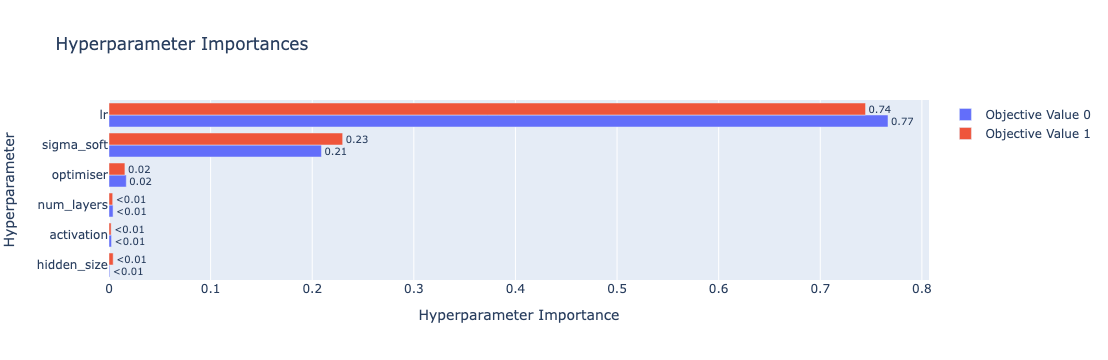

In [35]:
from optuna.visualization import (
    plot_optimization_history,
    plot_intermediate_values,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_contour,
    plot_slice,
    plot_edf,            
    plot_pareto_front,  
)

fig = plot_param_importances(study)
fig.show()                  

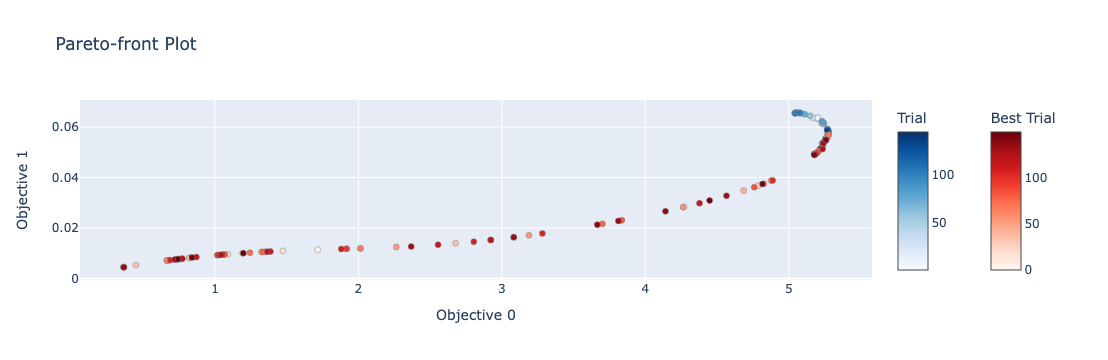

In [36]:
fig = plot_pareto_front(study)
fig.show()

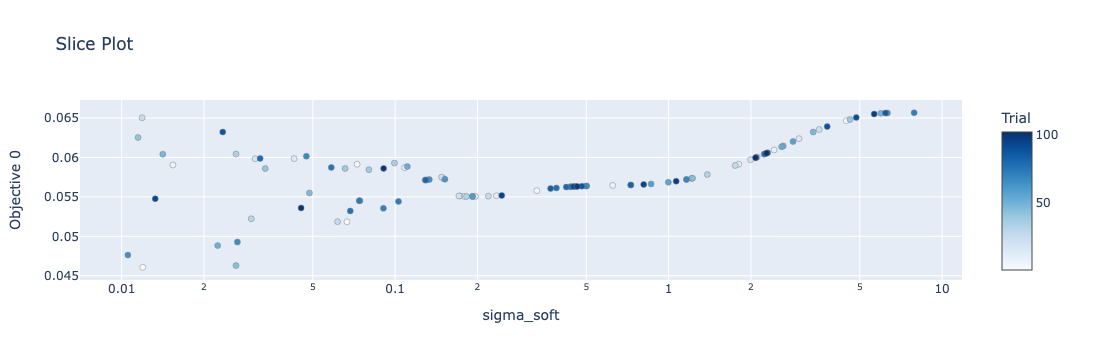

In [12]:
fig = plot_slice(
    study,
    params=['sigma_soft'],
    target=lambda t: t.values[1],   # 0 for first objective, 1 for second
    target_name='Objective 0'       # axis label
)
fig.show()

In [3]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.colors import Normalize

<>:40: SyntaxWarning: invalid escape sequence '\w'
<>:40: SyntaxWarning: invalid escape sequence '\w'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/2909745481.py:40: SyntaxWarning: invalid escape sequence '\w'
  ax.set_ylabel("SE of Evaluation Value Function $\widehat{V}_0^{\\theta}$")


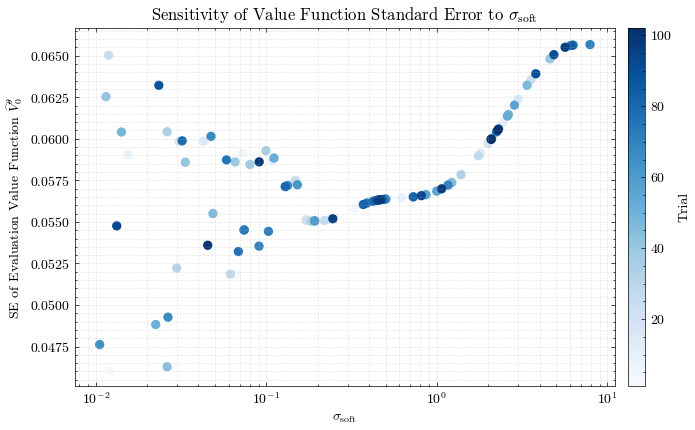

In [51]:
STUDY_NAME      = "sigma_optimisation_with_se"
STORAGE         = storage
OBJECTIVE_INDEX = 1                           
FIGSIZE         = (7.5, 4.5)

study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE)

records = []
for t in study.trials:
    if t.state == optuna.trial.TrialState.COMPLETE:
        sigma = t.params.get("sigma_soft")
        vals  = t.values
        if sigma is not None and vals is not None:
            records.append((t.number, sigma, vals[OBJECTIVE_INDEX]))

df = pd.DataFrame(records, columns=["trial", "sigma_soft", "objective"])

with plt.style.context(['science', 'no-latex']):
    plt.rcParams.update({                 # force black text everywhere
        'text.color'      : 'black',
        'axes.labelcolor' : 'black',
        'axes.edgecolor'  : 'black',
        'xtick.color'     : 'black',
        'ytick.color'     : 'black',
    })

    fig, ax = plt.subplots(figsize=FIGSIZE)

    sc = ax.scatter(
        df["sigma_soft"],
        df["objective"],
        c=df["trial"],
        cmap="Blues",
        s=45,
        edgecolor="none",
    )

    ax.set_xscale("log")
    ax.set_xlabel(r'$\sigma_{\mathrm{soft}}$')
    ax.set_ylabel("SE of Evaluation Value Function $\widehat{V}_0^{\\theta}$")
    ax.set_title(r'Sensitivity of Value Function Standard Error to $\sigma_{\mathrm{soft}}$')

    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)

    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    cbar = fig.colorbar(sc, ax=ax, label="Trial", pad=0.02)
    cbar.ax.yaxis.set_tick_params(color='black')
    cbar.outline.set_edgecolor('black')
    for tick in cbar.ax.get_yticklabels():
        tick.set_color('black')

    fig.tight_layout()
    plt.savefig('sigma_soft_slice_var.pdf')

    plt.show()


<>:35: SyntaxWarning: invalid escape sequence '\w'
<>:35: SyntaxWarning: invalid escape sequence '\w'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/2588108719.py:35: SyntaxWarning: invalid escape sequence '\w'
  ax.set_ylabel("Mean Evaluation Value Function $\widehat{V}_0^{\\theta}$")


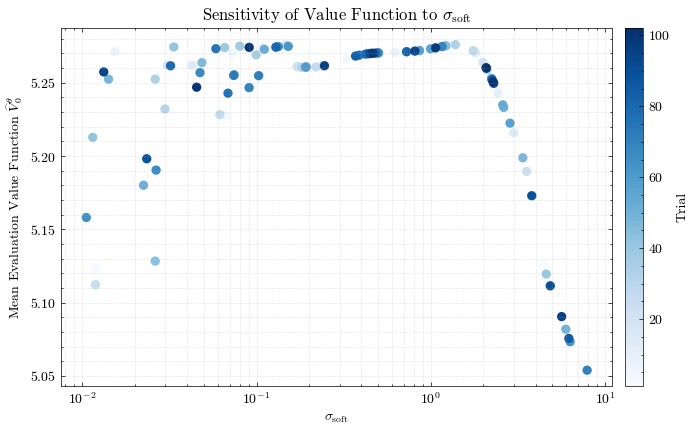

In [52]:
OBJECTIVE_INDEX = 0

records = []
for t in study.trials:
    if t.state == optuna.trial.TrialState.COMPLETE:
        sigma = t.params.get("sigma_soft")
        vals  = t.values
        if sigma is not None and vals is not None:
            records.append((t.number, sigma, vals[OBJECTIVE_INDEX]))

df = pd.DataFrame(records, columns=["trial", "sigma_soft", "objective"])

with plt.style.context(['science', 'no-latex']):
    plt.rcParams.update({               
        'text.color'      : 'black',
        'axes.labelcolor' : 'black',
        'axes.edgecolor'  : 'black',
        'xtick.color'     : 'black',
        'ytick.color'     : 'black',
    })

    fig, ax = plt.subplots(figsize=FIGSIZE)

    sc = ax.scatter(
        df["sigma_soft"],
        df["objective"],
        c=df["trial"],
        cmap="Blues",
        s=45,
        edgecolor="none",
    )

    ax.set_xscale("log")
    ax.set_xlabel(r'$\sigma_{\mathrm{soft}}$')
    ax.set_ylabel("Mean Evaluation Value Function $\widehat{V}_0^{\\theta}$")
    ax.set_title(r'Sensitivity of Value Function to $\sigma_{\mathrm{soft}}$')

    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)

    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    cbar = fig.colorbar(sc, ax=ax, label="Trial", pad=0.02)
    cbar.ax.yaxis.set_tick_params(color='black')
    cbar.outline.set_edgecolor('black')
    for tick in cbar.ax.get_yticklabels():
        tick.set_color('black')

    fig.tight_layout()
    plt.savefig('sigma_soft_slice_mean.pdf')

    plt.show()

<>:31: SyntaxWarning: invalid escape sequence '\w'
<>:31: SyntaxWarning: invalid escape sequence '\w'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/1438709275.py:31: SyntaxWarning: invalid escape sequence '\w'
  ax.set_title("Empirical CDF of Optimised Evaluation Value Function $\widehat{V}_0^{\\theta}$")


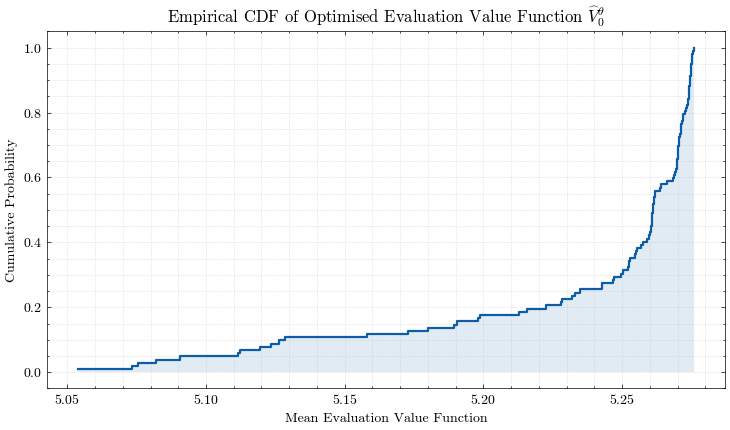

In [53]:
OBJ_INDEX = 0

rewards = np.array([
    t.values[OBJ_INDEX] for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE and t.values is not None
])

if rewards.size == 0:
    raise ValueError("No completed trials with the specified objective found.")

# sort for ECDF
x = np.sort(rewards)
y = np.arange(1, len(x) + 1) / len(x)

with plt.style.context(['science', 'no-latex']):
    plt.rcParams.update({
        'text.color'      : 'black',
        'axes.labelcolor' : 'black',
        'axes.edgecolor'  : 'black',
        'xtick.color'     : 'black',
        'ytick.color'     : 'black',
    })

    fig, ax = plt.subplots(figsize=FIGSIZE)

    ax.step(x, y, where="post", linewidth=1.6)
    ax.fill_between(x, y, step="post", alpha=0.12)

    ax.set_xlabel("Mean Evaluation Value Function")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Empirical CDF of Optimised Evaluation Value Function $\widehat{V}_0^{\\theta}$")
    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)
    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    fig.tight_layout()
    plt.savefig('sigma_soft_CDF.pdf')

    plt.show();


<>:61: SyntaxWarning: invalid escape sequence '\z'
<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\z'
<>:63: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/4193426035.py:61: SyntaxWarning: invalid escape sequence '\z'
  ax.set_xlabel("Learning Rate ($\zeta$)")
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/4193426035.py:63: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title("Rank plot: Learning Rate & $\sigma_{\mathrm{soft}}$")


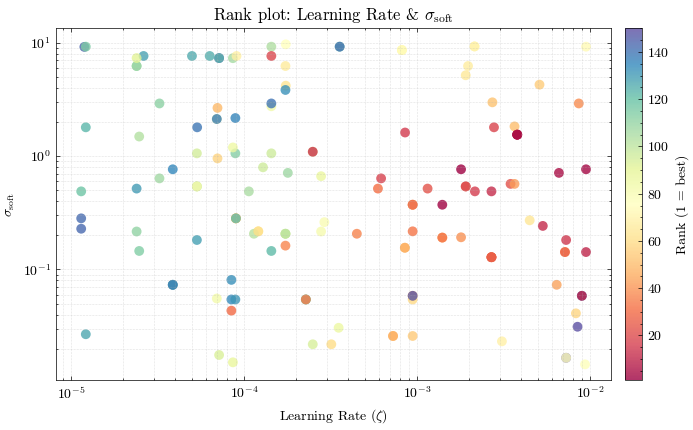

In [55]:
X_PARAM         = "lr"
Y_PARAM         = "sigma_soft"
FIGSIZE         = (7.5, 4.5)
RANK_LOWEST_IS_BEST = False           

study = optuna.load_study(study_name="architecture_optimisation", storage=storage)
records = []
for t in study.trials:
    if (
        t.state == optuna.trial.TrialState.COMPLETE
        and t.values is not None
        and X_PARAM in t.params
        and Y_PARAM in t.params
    ):
        records.append(
            (
                t.number,
                t.params[X_PARAM],
                t.params[Y_PARAM],
                t.values[OBJ_INDEX],
            )
        )

df = pd.DataFrame(records, columns=["trial", "x", "y", "objective"])
if df.empty:
    raise ValueError("No trials contain both parameters and the objective.")

asc = RANK_LOWEST_IS_BEST           
df["rank"] = df["objective"].rank(ascending=asc, method="min").astype(int)

with plt.style.context(["science", "no-latex"]):
    plt.rcParams.update(
        {
            "text.color": "black",
            "axes.labelcolor": "black",
            "axes.edgecolor": "black",
            "xtick.color": "black",
            "ytick.color": "black",
        }
    )

    fig, ax = plt.subplots(figsize=FIGSIZE)

    norm = Normalize(vmin=df["rank"].min(), vmax=df["rank"].max())
    cmap = plt.get_cmap("Spectral")  # darkest = rank 1 (best)

    sc = ax.scatter(
        df["x"],
        df["y"],
        c=df["rank"],
        cmap=cmap,
        norm=norm,
        s=50,
        edgecolor="none",
        alpha=0.8,
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.set_xlabel("Learning Rate ($\zeta$)")
    ax.set_ylabel(r"$\sigma_{\mathrm{soft}}$")
    ax.set_title("Rank plot: Learning Rate & $\sigma_{\mathrm{soft}}$")
    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)
    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    cbar = fig.colorbar(sc, ax=ax, pad=0.02, label="Rank (1 = best)")
    cbar.ax.yaxis.set_tick_params(color="black")
    cbar.outline.set_edgecolor("black")
    for tick in cbar.ax.get_yticklabels():
        tick.set_color("black")

    fig.tight_layout()
    plt.savefig('rankplot.pdf')
    plt.show()


<>:28: SyntaxWarning: invalid escape sequence '\w'
<>:28: SyntaxWarning: invalid escape sequence '\w'
/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/1356747039.py:28: SyntaxWarning: invalid escape sequence '\w'
  ax.set_title("Empirical CDF of Evaluation Value Function $\widehat{V}_0^{\\theta}$")


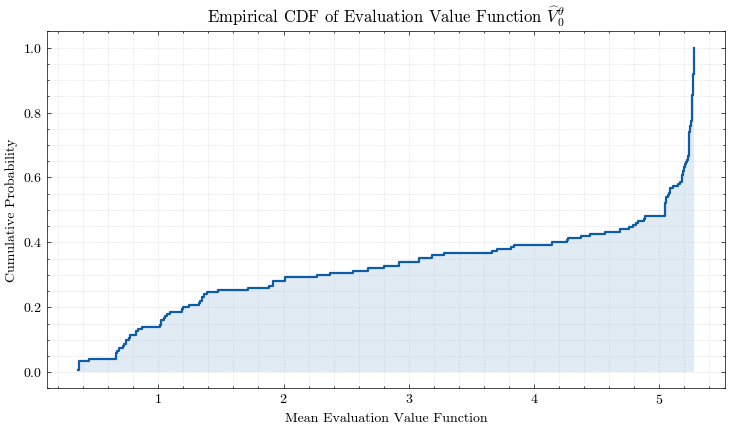

In [56]:
rewards = np.array([
    t.values[OBJ_INDEX] for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE and t.values is not None
])

if rewards.size == 0:
    raise ValueError("No completed trials with the specified objective found.")

x = np.sort(rewards)
y = np.arange(1, len(x) + 1) / len(x)

with plt.style.context(['science', 'no-latex']):
    plt.rcParams.update({
        'text.color'      : 'black',
        'axes.labelcolor' : 'black',
        'axes.edgecolor'  : 'black',
        'xtick.color'     : 'black',
        'ytick.color'     : 'black',
    })

    fig, ax = plt.subplots(figsize=FIGSIZE)

    ax.step(x, y, where="post", linewidth=1.6)
    ax.fill_between(x, y, step="post", alpha=0.12)

    ax.set_xlabel("Mean Evaluation Value Function")
    ax.set_ylabel("Cumulative Probability")
    ax.set_title("Empirical CDF of Evaluation Value Function $\widehat{V}_0^{\\theta}$")
    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)
    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    fig.tight_layout()
    plt.savefig('all_param_CDF.pdf')

    plt.show()


/var/folders/zk/dqjkccp920l54p525wpt9gqr0000gn/T/ipykernel_77143/104913756.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.84, 1])


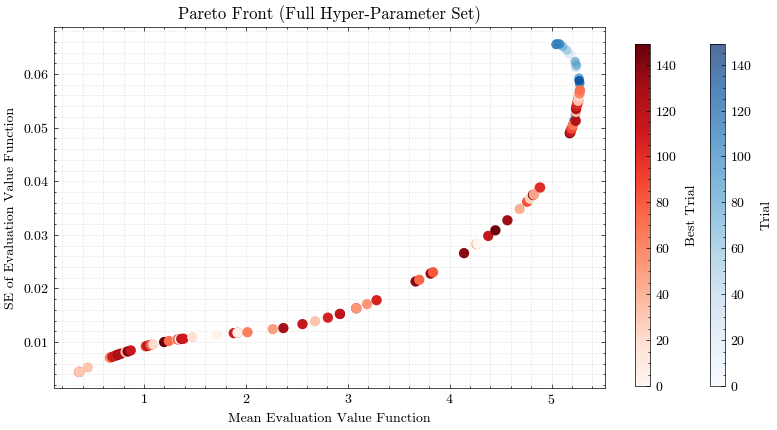

In [57]:
OBJ_X, OBJ_Y     = 0, 1           
FIGSIZE          = (7.5, 4.5)

records = [
    (t.number, t.values[OBJ_X], t.values[OBJ_Y])
    for t in study.trials
    if t.state == optuna.trial.TrialState.COMPLETE and t.values is not None
]
if not records:
    raise ValueError("No completed trials with required objectives found.")

trial_no, x_all, y_all = zip(*records)
trial_no = np.array(trial_no)
obj_mat  = np.column_stack([x_all, y_all])         

def pareto_mask_mixed(pts: np.ndarray) -> np.ndarray:
    n = pts.shape[0]
    is_eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_eff[i]:
            continue
        dominates = (
            (pts[is_eff, 0] >= pts[i, 0]) &
            (pts[is_eff, 1] <= pts[i, 1]) &
            ((pts[is_eff, 0] > pts[i, 0]) |
             (pts[is_eff, 1] < pts[i, 1]))
        )
        is_eff[i] = not dominates.any()
    return is_eff

mask_best   = pareto_mask_mixed(obj_mat)
best_pts    = obj_mat[mask_best]
best_trials = trial_no[mask_best]
dom_pts     = obj_mat[~mask_best]
dom_trials  = trial_no[~mask_best]

order       = np.argsort(best_pts[:, 0])
best_pts    = best_pts[order]
best_trials = best_trials[order]

with plt.style.context(["science", "no-latex"]):
    plt.rcParams.update({
        "text.color"      : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor"  : "black",
        "xtick.color"     : "black",
        "ytick.color"     : "black",
    })

    fig, ax = plt.subplots(figsize=FIGSIZE)

    norm = Normalize(vmin=trial_no.min(), vmax=trial_no.max())

    # dominated trials = blue
    sc_dom = ax.scatter(dom_pts[:, 0], dom_pts[:, 1],
                        c=dom_trials, cmap="Blues", norm=norm,
                        s=45, alpha=0.7, edgecolor="none", zorder=1)

    # best trials = red
    sc_best = ax.scatter(best_pts[:, 0], best_pts[:, 1],
                         c=best_trials, cmap="Reds", norm=norm,
                         s=55, edgecolor="none", zorder=4)

    ax.set_xlabel("Mean Evaluation Value Function")
    ax.set_ylabel("SE of Evaluation Value Function")
    ax.set_title("Pareto Front (Full Hyper-Parameter Set)")
    ax.grid(True, which="both", linestyle=":", linewidth=0.4, alpha=0.7)
    ax.set_facecolor("none")
    fig.patch.set_alpha(0)

    cax2 = fig.add_axes([0.86, 0.12, 0.02, 0.76])
    cbar2 = fig.colorbar(sc_best, cax=cax2)
    cbar2.set_label("Best Trial", rotation=90, labelpad=6, color="black")
    cbar2.ax.yaxis.set_tick_params(color="black")
    cbar2.outline.set_edgecolor("black")
    for t in cbar2.ax.get_yticklabels():
        t.set_color("black")

    cax1 = fig.add_axes([0.96, 0.12, 0.02, 0.76])
    cbar1 = fig.colorbar(sc_dom, cax=cax1)
    cbar1.set_label("Trial", rotation=90, labelpad=6, color="black")
    cbar1.ax.yaxis.set_tick_params(color="black")
    cbar1.outline.set_edgecolor("black")
    for t in cbar1.ax.get_yticklabels():
        t.set_color("black")

    fig.tight_layout(rect=[0, 0, 0.84, 1])           
    fig.savefig("pareto_front_best_cmap.pdf")
    plt.show()
